# Lab 5: NLI with Attention

In this assignment we train an attention model for NLI based on [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) initial (non word-by-word) model.

## Setup

You'll need to download and unzip SNLI, which you can find [here](http://nlp.stanford.edu/projects/snli/). Set `snli_home` below to point to it. The following block of code loads it.

This will take a couple of minutes to run if you load whole data, so you may want to start editing the code below at the same time. As it is now, the code is ready for debugging, it only loads 1000 examples.

You'll use Glove embeddings as well. If you dowloaded for the assignment 3 then edit `glove_home` to point the correct embedding file. Otherwise, if need to download them, You can do it at the following [url](http://nlp.stanford.edu/data/glove.6B.zip) (1GB). The zip file includes embeddings of different dimensionality (50d, 100d, 200d, 300d) for a vocabulary of 400000 words. Decompress them and place somewhere, for example in `./embeddings/` folder.

In [1]:
snli_home = './data/snli_1.0/'

import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f):
            if i >= 1000000:  # Edit to use less data for debugging. set to 1000000 for testing.
                break
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl')

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary (for a class exercise) of about 36k words.

In [2]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [3]:
print(training_set[6])
print(len(word_indices))

{'sentence1_binary_parse_index_sequence': array([33450,  3966, 35411, 35113, 19734, 14836,  2279,   556, 17418,    99], dtype=int32), 'sentence2_parse': '(ROOT (S (NP (DT A) (NN miss)) (VP (VBZ holds) (NP (NP (NNS pieces)) (PP (IN of) (NP (NN nature))))) (. .)))', 'sentence2': 'A miss holds pieces of nature.', 'sentence1': 'A little black girl is holding rocks in her hand.', 'gold_label': 'entailment', 'captionID': '5574382134.jpg#2', 'sentence1_binary_parse': '( ( A ( little ( black girl ) ) ) ( ( is ( ( holding rocks ) ( in ( her hand ) ) ) ) . ) )', 'pairID': '5574382134.jpg#2r1e', 'sentence1_parse': '(ROOT (S (NP (DT A) (JJ little) (JJ black) (NN girl)) (VP (VBZ is) (NP (NP (VBG holding) (NNS rocks)) (PP (IN in) (NP (PRP$ her) (NN hand))))) (. .)))', 'sentence2_binary_parse_index_sequence': array([    0,     0,     0, 35196, 32978, 33632,  1058,  2918, 15612,    99], dtype=int32), 'label': 0, 'annotator_labels': ['entailment'], 'sentence2_binary_parse': '( ( A miss ) ( ( holds ( pi

Now we load GloVe. You'll need to decompress the file in 'data' folder.  You'll need the same file that you used for the in-class exercise on word embeddings.

In [4]:
glove_home = './data/'
words_to_load = 45000

with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

word = 'dog'
word_ind = word_indices[word]
print('Loaded embedding for {}:\n{}'.format(word,loaded_embeddings[word_ind]))

Loaded embedding for dog:
[ 0.11008    -0.38780999 -0.57615    -0.27713999  0.70520997  0.53994
 -1.07860005 -0.40145999  1.15040004 -0.56779999  0.0038977   0.52877998
  0.64560997  0.47262001  0.48548999 -0.18407001  0.18009999  0.91396999
 -1.19790006 -0.57779998 -0.37985     0.33605999  0.77200001  0.75555003
  0.45506001 -1.76709998 -1.0503      0.42566001  0.41892999 -0.68326998
  1.56729996  0.27684999 -0.61707997  0.64638001 -0.076996    0.37118
  0.13079999 -0.45137     0.25398001 -0.74392003 -0.086199    0.24067999
 -0.64819002  0.83548999  1.25020003 -0.51379001  0.04224    -0.88117999
  0.71579999  0.38519001]


Now we set up an evaluation function as before.

In [5]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignments: Build GRU pair with attention 

Run the first block of code right away to make sure you have the proper dependencies. If you are working on your machine, you may need to install [matplotlib](http://matplotlib.org/users/installing.html), which should be fairly straightforward.

### TODO:
- Fill in the missing componant below to complete Rocktäschel-style attention. Details of the attention mechanism are described in Section 2.3 of the [paper](https://arxiv.org/pdf/1509.06664v4.pdf).

![](main_arc.png)
- More specifically you need to implement the following two equations:
![](eq_to_implement.png)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf

In [18]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 20  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print out cost statistics (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 24  # The dimension of the hidden state of the RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        
        # Define the parameters
        self.E = tf.Variable(loaded_embeddings, trainable=False)
        
        self.W_rnn = {}
        self.W_r = {}
        self.W_z = {}
        self.b_rnn = {}
        self.b_r = {}
        self.b_z = {}
        
        for name in ['p', 'h']:
            in_dim = self.embedding_dim
            
            self.W_rnn[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_rnn[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

            self.W_r[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_r[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

            self.W_z[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_z[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))         

        # TODO: You'll need to use these three parameters.
        self.W_h_attn = tf.Variable(tf.random_normal([self.dim, self.dim], stddev=0.1))
        self.W_y_attn = tf.Variable(tf.random_normal([self.dim, self.dim], stddev=0.1))
        self.w_attn = tf.Variable(tf.random_normal([self.dim, 1], stddev=0.1))

        self.W_combination = tf.Variable(tf.random_normal([2 * self.dim, self.dim], stddev=0.1))
        self.b_combination = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        self.W_cl = tf.Variable(tf.random_normal([self.dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random_normal([3], stddev=0.1))
        
        # Define the placeholders
        self.premise_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.hypothesis_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.y = tf.placeholder(tf.int32, [None])
        
        # Define the GRU function
        def gru(emb, h_prev, name):
            emb_h_prev = tf.concat([emb, h_prev], 1, name=name + '_emb_h_prev')
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z[name])  + self.b_z[name], name=name + '_z')
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r[name])  + self.b_r[name], name=name + '_r')
            emb_r_h_prev = tf.concat([emb, r * h_prev], 1, name=name + '_emb_r_h_prev')
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn[name])  + self.b_rnn[name], name=name + '_h_tilde')
            h = (1. - z) * h_prev + z * h_tilde
            return h
        
        # Define one step of the premise encoder RNN
        def premise_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'p')
        
        # Define one step of the hypothesis encoder RNN
        def hypothesis_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'h')

        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(self.premise_x, self.sequence_length, 1)
        self.x_hypothesis_slices = tf.split(self.hypothesis_x, self.sequence_length, 1)
        
        self.h_zero = tf.zeros(tf.stack([tf.shape(self.premise_x)[0], self.dim]))
        
        # Unroll the first RNN
        premise_h_prev = self.h_zero
        premise_steps_list = []

        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            premise_h_prev = premise_step(x_t, premise_h_prev)
            premise_steps_list.append(premise_h_prev)
            
        premise_steps = tf.stack(premise_steps_list, axis=1, name='premise_steps')
 
        # Unroll the second RNN
        h_prev_hypothesis = premise_h_prev  # Continue running the same RNN
        
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            h_prev_hypothesis = hypothesis_step(x_t, h_prev_hypothesis)
        
        # Do attention
        wm_list = []
        wh_hn=tf.matmul(h_prev_hypothesis,self.W_h_attn)
        # TODO: Fill wm_list with one scalar (a.k.a., vector with one scalar for each batch entry)
        # for each word in the premise.
        # This'll likely be easiest if you use a loop to iterate over timesteps.
        # You should use the three `attn` parameters defined above, as well as `premise_steps_list`.
        for t in range(self.sequence_length):
            y = premise_steps_list[t]            
            M = tf.tanh(tf.matmul(y,self.W_y_attn) + wh_hn)            
            attention_t = tf.matmul(M,self.w_attn)
            wm_list.append(attention_t)
        
        # End above TODO
        
        wm = tf.stack(wm_list, axis=1)        
        
        self.attn_weights = tf.nn.softmax(wm, dim=1)
        attn_result = tf.reduce_sum(tf.multiply(self.attn_weights, premise_steps, name='attn_result_unsummed'),
                                    1, name='attn_result')
        
        # Combine the results of attention with the final GRU state
        concat_features = tf.concat([attn_result, h_prev_hypothesis], 1, name=name + '_emb_h_prev')
        pair_features = tf.nn.tanh(tf.matmul(concat_features, self.W_combination) + self.b_combination)
        
        # Compute the logits
        self.logits = tf.matmul(pair_features, self.W_cl) + self.b_cl
        
        # Define the cost function (here, the softmax exp and sum are built in)
        self.total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
        
        # This  performs the main SGD update equation with gradient clipping
        optimizer_obj = tf.train.AdamOptimizer()
        gvs = optimizer_obj.compute_gradients(self.total_cost)
        capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
        self.optimizer = optimizer_obj.apply_gradients(capped_gvs)
        
        # Create an operation to fill zero values in for W and b
        self.init = tf.global_variables_initializer()

        # Create a placeholder for the session that will be shared between training and evaluation
        self.sess = tf.Session()
        
        # Initialize variables
        self.sess.run(self.init)
        self.step = 1
        self.epoch = 1
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print('Training.')

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                _, c = self.sess.run(
                     [self.optimizer, self.total_cost], 
                     feed_dict={self.premise_x: minibatch_premise_vectors,
                                self.hypothesis_x: minibatch_hypothesis_vectors,
                                self.y: minibatch_labels})

                if self.step % self.display_step_freq == 0:
                    print("Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000]))
                                  
                self.step += 1
                avg_cost += c / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if self.epoch % self.display_epoch_freq == 0:
                print ("Epoch:", self.epoch, "Cost:", avg_cost) 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits = self.sess.run(self.logits,
                               feed_dict={self.premise_x: premise_vectors,
                                          self.hypothesis_x: hypothesis_vectors})

        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        attn_weights = self.sess.run(self.attn_weights, 
                                     feed_dict={self.premise_x: premise_vectors,
                                                self.hypothesis_x: hypothesis_vectors})
        return np.reshape(attn_weights, [len(examples), 10, 1])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(np.transpose(attn_weights[i,:,:]), vmin=0., vmax=1., cmap=plt.cm.inferno)
            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]
            plt.text(0, 1, 'H: ' + ' '.join(hypothesis_tokens))
            ax.set_xticklabels(premise_tokens, rotation=45)
            plt.xticks(np.arange(0, 10, 1.0))

Next, create an instance of the model. Unlike in previous exercises, initialization happens here, rather than at the start of training. You can now initialize a model once and start and stop training as needed.

In [19]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

In implementing attention, it's easy to accidentally mix information between different examples in a batch. This assertion will fail if you've done so. Run it whenever you edit core model code.

In [20]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).all(), \
       'Warning: There is cross-example information flow.'

Running the training long enough __on the whole training set__, you may get around 62% dev accuracy. This should take around five or ten minutes (or maybe more). This isn't great performance, but it's good enough that we should start to see attention play a role. If you have extra time, run longer.

In [21]:
classifier.train(training_set, dev_set)

Training.
Step: 250 Dev acc: 0.513 Train acc: 0.52
Step: 500 Dev acc: 0.542 Train acc: 0.549
Step: 750 Dev acc: 0.556 Train acc: 0.568
Step: 1000 Dev acc: 0.569 Train acc: 0.565
Step: 1250 Dev acc: 0.574 Train acc: 0.593
Step: 1500 Dev acc: 0.573 Train acc: 0.604
Step: 1750 Dev acc: 0.581 Train acc: 0.594
Step: 2000 Dev acc: 0.596 Train acc: 0.588
Step: 2250 Dev acc: 0.589 Train acc: 0.591
Step: 2500 Dev acc: 0.593 Train acc: 0.595
Step: 2750 Dev acc: 0.606 Train acc: 0.598
Step: 3000 Dev acc: 0.608 Train acc: 0.595
Step: 3250 Dev acc: 0.601 Train acc: 0.587
Step: 3500 Dev acc: 0.604 Train acc: 0.613
Step: 3750 Dev acc: 0.6 Train acc: 0.598
Step: 4000 Dev acc: 0.62 Train acc: 0.595
Step: 4250 Dev acc: 0.612 Train acc: 0.609
Step: 4500 Dev acc: 0.617 Train acc: 0.607
Step: 4750 Dev acc: 0.618 Train acc: 0.6
Step: 5000 Dev acc: 0.613 Train acc: 0.605
Step: 5250 Dev acc: 0.61 Train acc: 0.621
Step: 5500 Dev acc: 0.601 Train acc: 0.627
Step: 5750 Dev acc: 0.602 Train acc: 0.619
Step: 6000 

Step: 46500 Dev acc: 0.688 Train acc: 0.653
Step: 46750 Dev acc: 0.67 Train acc: 0.662
Step: 47000 Dev acc: 0.675 Train acc: 0.68
Step: 47250 Dev acc: 0.669 Train acc: 0.677
Step: 47500 Dev acc: 0.669 Train acc: 0.657
Step: 47750 Dev acc: 0.674 Train acc: 0.662
Step: 48000 Dev acc: 0.661 Train acc: 0.679
Step: 48250 Dev acc: 0.664 Train acc: 0.66
Step: 48500 Dev acc: 0.664 Train acc: 0.666
Step: 48750 Dev acc: 0.672 Train acc: 0.678
Step: 49000 Dev acc: 0.67 Train acc: 0.665
Step: 49250 Dev acc: 0.677 Train acc: 0.653
Step: 49500 Dev acc: 0.682 Train acc: 0.672
Step: 49750 Dev acc: 0.678 Train acc: 0.669
Step: 50000 Dev acc: 0.676 Train acc: 0.662
Step: 50250 Dev acc: 0.671 Train acc: 0.663
Step: 50500 Dev acc: 0.669 Train acc: 0.681
Step: 50750 Dev acc: 0.677 Train acc: 0.672
Step: 51000 Dev acc: 0.673 Train acc: 0.674
Step: 51250 Dev acc: 0.673 Train acc: 0.672
Epoch: 6 Cost: 0.0118622468462
Step: 51500 Dev acc: 0.668 Train acc: 0.675
Step: 51750 Dev acc: 0.664 Train acc: 0.681
Step:

Step: 92500 Dev acc: 0.685 Train acc: 0.689
Step: 92750 Dev acc: 0.67 Train acc: 0.695
Step: 93000 Dev acc: 0.688 Train acc: 0.69
Step: 93250 Dev acc: 0.67 Train acc: 0.699
Step: 93500 Dev acc: 0.675 Train acc: 0.693
Step: 93750 Dev acc: 0.679 Train acc: 0.679
Step: 94000 Dev acc: 0.679 Train acc: 0.697
Step: 94250 Dev acc: 0.681 Train acc: 0.698
Epoch: 11 Cost: 0.0115342508806
Step: 94500 Dev acc: 0.684 Train acc: 0.718
Step: 94750 Dev acc: 0.677 Train acc: 0.717
Step: 95000 Dev acc: 0.676 Train acc: 0.703
Step: 95250 Dev acc: 0.675 Train acc: 0.704
Step: 95500 Dev acc: 0.676 Train acc: 0.709
Step: 95750 Dev acc: 0.68 Train acc: 0.7
Step: 96000 Dev acc: 0.675 Train acc: 0.697
Step: 96250 Dev acc: 0.678 Train acc: 0.703
Step: 96500 Dev acc: 0.676 Train acc: 0.706
Step: 96750 Dev acc: 0.679 Train acc: 0.708
Step: 97000 Dev acc: 0.682 Train acc: 0.702
Step: 97250 Dev acc: 0.678 Train acc: 0.7
Step: 97500 Dev acc: 0.686 Train acc: 0.711
Step: 97750 Dev acc: 0.678 Train acc: 0.694
Step: 98

Step: 137500 Dev acc: 0.682 Train acc: 0.706
Step: 137750 Dev acc: 0.681 Train acc: 0.7
Step: 138000 Dev acc: 0.694 Train acc: 0.703
Step: 138250 Dev acc: 0.688 Train acc: 0.706
Step: 138500 Dev acc: 0.684 Train acc: 0.7
Step: 138750 Dev acc: 0.678 Train acc: 0.7
Step: 139000 Dev acc: 0.667 Train acc: 0.702
Step: 139250 Dev acc: 0.68 Train acc: 0.696
Step: 139500 Dev acc: 0.673 Train acc: 0.712
Step: 139750 Dev acc: 0.668 Train acc: 0.697
Step: 140000 Dev acc: 0.669 Train acc: 0.694
Step: 140250 Dev acc: 0.678 Train acc: 0.693
Step: 140500 Dev acc: 0.676 Train acc: 0.699
Step: 140750 Dev acc: 0.684 Train acc: 0.699
Step: 141000 Dev acc: 0.685 Train acc: 0.704
Step: 141250 Dev acc: 0.679 Train acc: 0.696
Step: 141500 Dev acc: 0.675 Train acc: 0.692
Step: 141750 Dev acc: 0.677 Train acc: 0.684
Step: 142000 Dev acc: 0.686 Train acc: 0.685
Step: 142250 Dev acc: 0.683 Train acc: 0.687
Step: 142500 Dev acc: 0.673 Train acc: 0.682
Step: 142750 Dev acc: 0.672 Train acc: 0.684
Step: 143000 Dev 

## Visualization

This will print some (NYU-colored) visualizations for the first ten dev examples. Explore these examples and more, and see if you can identify any patterns in what the model has learned.

/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


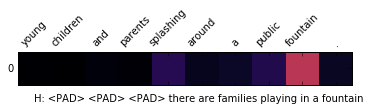

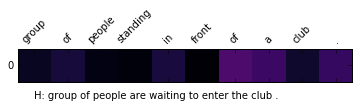

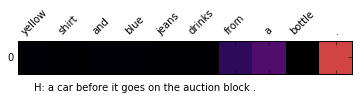

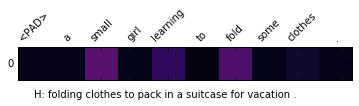

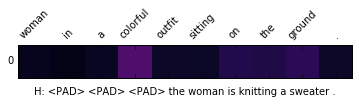

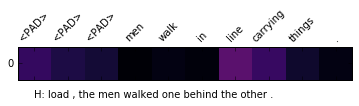

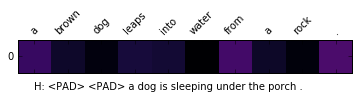

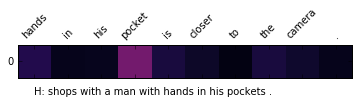

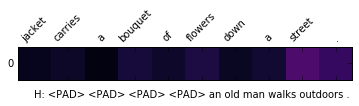

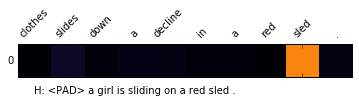

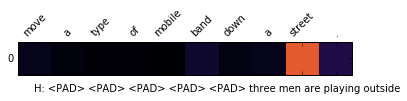

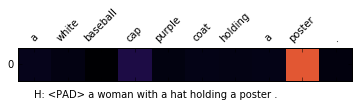

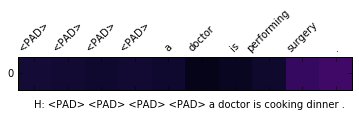

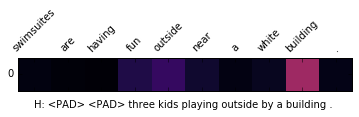

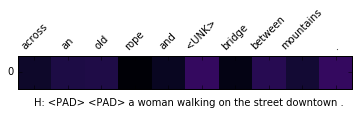

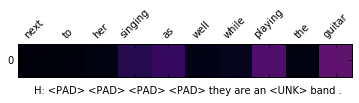

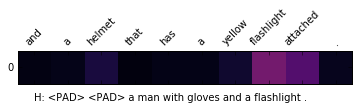

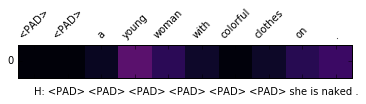

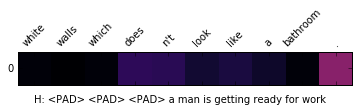

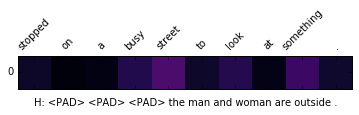

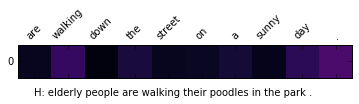

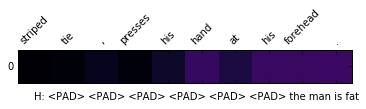

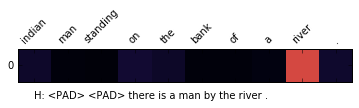

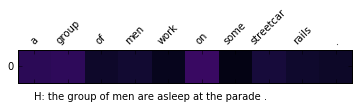

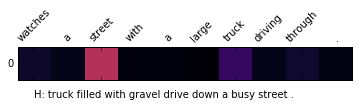

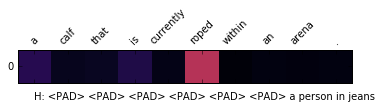

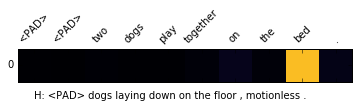

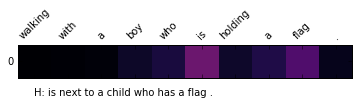

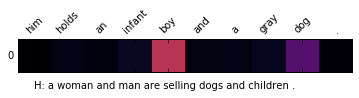

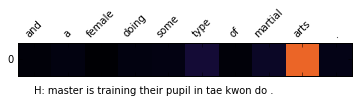

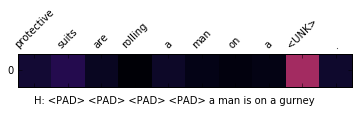

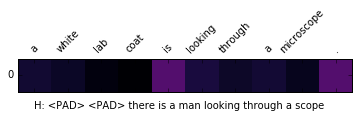

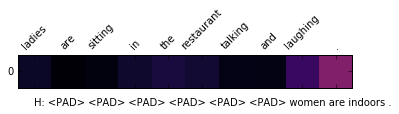

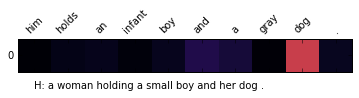

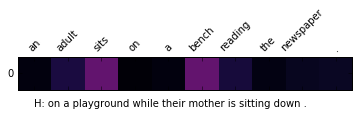

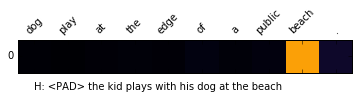

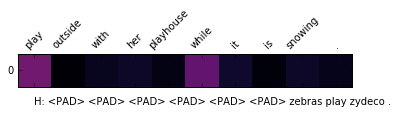

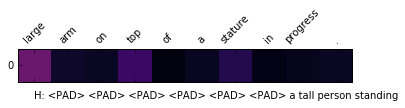

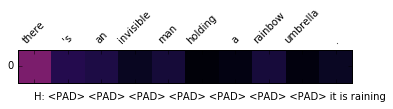

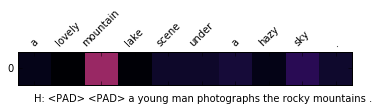

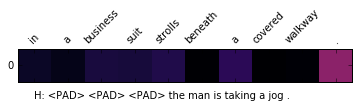

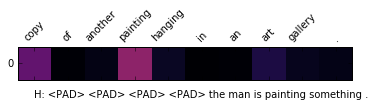

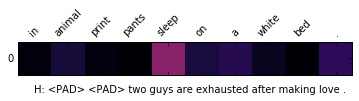

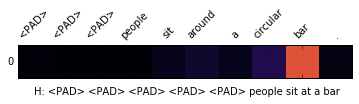

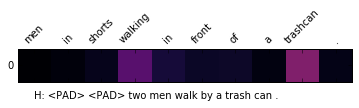

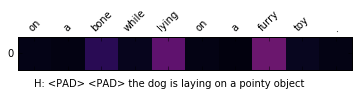

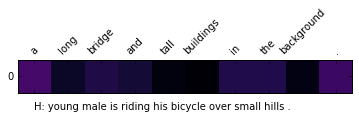

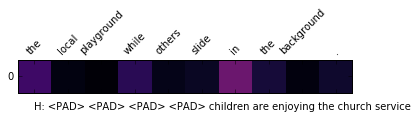

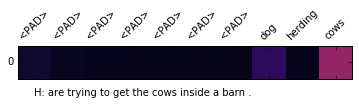

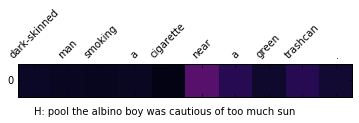

In [22]:
classifier.plot_attn(dev_set[0:50])

# Atribution:
Adapted by Oier Lopez de Lacalle, based on a notebook by Sam Bowman at NYU